<a href="https://colab.research.google.com/github/abinayaa123/ME592/blob/main/ME592_ESHM_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ME592 Engineering Systems Health Monitoring - HW3

March 31, 2022

Abinayaa Dhanagopal (Task 2), Casey Robinson (Task 2), Henry Croll (Task 2), Nianyu Jiang (Task 1), Timilehin Ayanlade (Task 1)

Homework was divided by task, with each team member working on the entirety of that task, then collaborating/combining with the other team member(s) assigned to that task. Ultimately, entire team reviewed code for full homework.

# Task 1 - Occupancy Detection LSTM

## Part 1 editted by Nianyu Jiang at March 28th ##

Source code: https://cnvrg.io/pytorch-lstm/
Credit to: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In this part I edited the code based on the example code from class
I added another better LSTM module for faster error reduce

In [ ]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from tensorflow import keras
# Highly recommended for time series data
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# Processing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# keras --2019--> tf.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# upload all the datasets
Data_train = read_csv('datatraining.txt')
Data_test1 = read_csv('datatest.txt')
Data_test2 = read_csv('datatest2.txt')
del Data_train['date']
del Data_test1['date']
del Data_test2['date']
Data_train.to_csv('Data_train.csv')
Data_test1.to_csv('Data_test1.csv')
Data_test2.to_csv('Data_test2.csv')
# print(Data_test2)

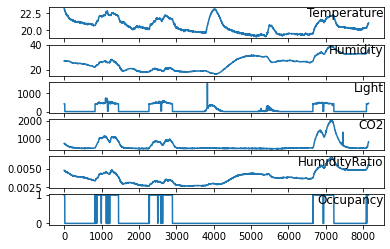

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [ ]:
# give a look at the data
# load dataset
dataset = read_csv('Data_train.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
dataset.describe() # Awesome for data summary!

I believe we have to use the 6 features to predict occupancy feature.

Data Processing

* Encode categorical data
* Scaling
* *series_to_supervised()*

In [ ]:
# prepare data for lstm
# convert series to supervised learning  --> stride missing?, spaced out the data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # create 1 time lag
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Test on multi time lag

In [ ]:
# load dataset
dataset = read_csv('Data_train.csv', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3 # Previously = 1
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(8140, 24)


In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 7 * 30 * 24 # look at 7 month data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

####
# split into input and outputs
n_obs = n_hours * n_features # count in the 6 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
####

(5040, 18) (5040,)
(5040, 3, 6) (5040,) (3100, 3, 6) (3100,)


In [ ]:
# design and build up LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
79/79 - 4s - loss: 0.1549 - val_loss: 0.0428 - 4s/epoch - 49ms/step
Epoch 2/20
79/79 - 0s - loss: 0.0373 - val_loss: 0.0145 - 445ms/epoch - 6ms/step
Epoch 3/20
79/79 - 0s - loss: 0.0120 - val_loss: 0.0202 - 441ms/epoch - 6ms/step
Epoch 4/20
79/79 - 0s - loss: 0.0141 - val_loss: 0.0230 - 493ms/epoch - 6ms/step
Epoch 5/20
79/79 - 0s - loss: 0.0149 - val_loss: 0.0173 - 408ms/epoch - 5ms/step
Epoch 6/20
79/79 - 0s - loss: 0.0136 - val_loss: 0.0112 - 496ms/epoch - 6ms/step
Epoch 7/20
79/79 - 0s - loss: 0.0118 - val_loss: 0.0071 - 484ms/epoch - 6ms/step
Epoch 8/20
79/79 - 0s - loss: 0.0102 - val_loss: 0.0051 - 421ms/epoch - 5ms/step
Epoch 9/20
79/79 - 0s - loss: 0.0091 - val_loss: 0.0047 - 409ms/epoch - 5ms/step
Epoch 10/20
79/79 - 0s - loss: 0.0086 - val_loss: 0.0054 - 399ms/epoch - 5ms/step
Epoch 11/20
79/79 - 0s - loss: 0.0085 - val_loss: 0.0060 - 453ms/epoch - 6ms/step
Epoch 12/20
79/79 - 0s - loss: 0.0085 - val_loss: 0.0062 - 464ms/epoch - 6ms/step
Epoch 13/20
79/79 - 0s - lo

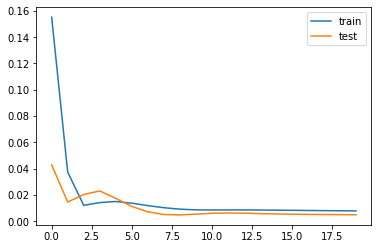

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

In [ ]:
#Saving the model

model.save("LSTM_model.h5")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


Validate the model based on the training data


In [ ]:
yhat = model.predict(test_X)

In [ ]:
yhat.shape

(3100, 1)

In [ ]:
# make a prediction
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features)) # back to (n, 16)

####
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -6:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the polt easier to see
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -6:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
####

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.088


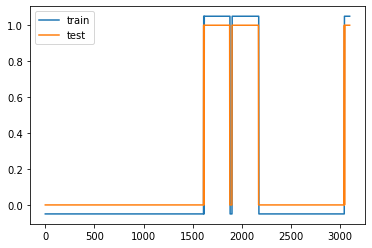

In [ ]:
# plot prediction and real result
pyplot.plot(inv_yhat, label='train')
pyplot.plot(inv_y, label='test')
pyplot.legend()
pyplot.show()

Validation on both test datasets

In [ ]:
# load dataset test1
test1 = read_csv('Data_test1.csv', header=0, index_col=0)
test1 = test1.values
# ensure all data is float
test1 = test1.astype('float32')
# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(test1)
# specify the number of lag hours
n_hours = 3 # Previously = 1
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
test1= reframed.values
test1_X, test1_y = test1[:, :n_obs], test1[:, -1]
print(test1_X.shape, test1_y.shape)
test1_X = test1_X.reshape((test1_X.shape[0], n_hours, n_features))
print(test1_X.shape, test1_y.shape)

(2662, 18) (2662,)
(2662, 3, 6) (2662,)


In [ ]:
# make a prediction on test data 1
y1hat = model.predict(test1_X)
test1_X = test1_X.reshape((test1_X.shape[0],  n_hours*n_features))
# invert scaling for forecast
inv_y1hat = concatenate((test1_X[:, -6:-1], y1hat), axis=1)
inv_y1hat = scaler.inverse_transform(inv_y1hat)
inv_y1hat = inv_y1hat[:,-1]
inv_y1hat = np.where(inv_y1hat < 0.1, -0.05, 1.05)
# invert scaling for actual
test1_y = test1_y.reshape((len(test1_y), 1))
inv_y1 = concatenate((test1_X[:, -6:-1], test1_y), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y1, inv_y1hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.142


In [ ]:
# load dataset test2
test2 = read_csv('Data_test2.csv', header=0, index_col=0)
test2 = test2.values
# ensure all data is float
test2 = test2.astype('float32')
# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(test2)
# specify the number of lag hours
n_hours = 3 # Previously = 1
n_features = 6
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
test2= reframed.values
test2_X, test2_y = test2[:, :n_obs], test2[:, -1]
print(test2_X.shape, test2_y.shape)
test2_X = test2_X.reshape((test2_X.shape[0], n_hours, n_features))
print(test2_X.shape, test2_y.shape)

(9749, 18) (9749,)
(9749, 3, 6) (9749,)


In [ ]:
# make a prediction on test data 2
y2hat = model.predict(test2_X)
test2_X = test2_X.reshape((test2_X.shape[0],  n_hours*n_features))
# invert scaling for forecast
inv_y2hat = concatenate((test2_X[:, -6:-1], y2hat), axis=1)
inv_y2hat = scaler.inverse_transform(inv_y2hat)
inv_y2hat = inv_y2hat[:,-1]
inv_y2hat = np.where(inv_y2hat < 0.1, -0.05, 1.05) 
# invert scaling for actual
test2_y = test2_y.reshape((len(test2_y), 1))
inv_y2 = concatenate((test2_X[:, -6:-1], test2_y), axis=1)
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y2, inv_y2hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.106


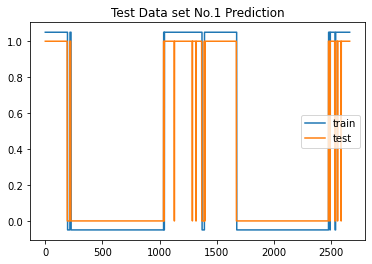

In [ ]:
# plot result
pyplot.plot(inv_y1hat, label='train')
pyplot.plot(inv_y1, label='test')
pyplot.title('Test Data set No.1 Prediction')
pyplot.legend()
pyplot.show()


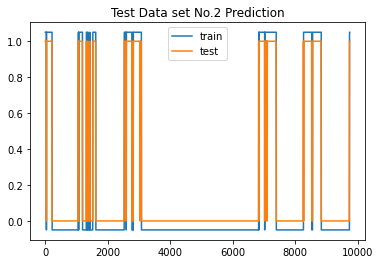

In [ ]:
# plot result
pyplot.plot(inv_y2hat, label='train')
pyplot.plot(inv_y2, label='test')
pyplot.title('Test Data set No.2 Prediction')
pyplot.legend()
pyplot.show()

### Conclusion ##
The LSTM model we built up can reach to a RMSE at two different test data set for 0.088 & 0.142.

## Part 2.
Learning rate = 0.001; optimizer is Adam; loss function is MSE; batch size = 64; epoch = 20; number of unit in LSTM block is 50 with 4 drop out layers.

## part 3.
See the plot in part 1.
Yes I see the decrease. Due to the drop off layers the loss stablized instead of fluctuate.

# Task 2 - Electricity Consumption and Occupancy LSTM

In [ ]:
#ME592 HW3 - Predict occupancy given energy consumption via stacked LSTM
#Developed before Abinayaa finished the entire data processing, not necessary to run anymore.

import pandas as pd
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
import numpy as np
import matplotlib.pyplot as plt

#Information for occupancy
#Two .csv files, one for winter, one for summer
#Summer date range: 5/30/12-9/1/12
#Winter date range: 11/30/12-1/15/13
#Data logged at 1Hz column-wise, first column gives date, next 86400 data, rows being different days

#Information for plugs
#.csv files, one for each date for each plug type
#Date range: generally 6/1/12-1/31/13 for 240 days coverage
#Data logged at 1Hz (86400 points), midnight to midnight
#Rows with missing measurements are denoted as "-1"

#Information for plugs folder convention
#01: Tablet (no. days: 240, coverage: 97.43%)
#02: Dishwasher (no. days: 240, coverage: 97.09%)
#03: Air exhaust (no. days: 240, coverage: 96.18%) (*)
#04: Fridge (no. days: 240, coverage: 98%)
#05: Entertainment (no. days: 240, coverage: 96.18%) (**)
#06: Freezer (no. days: 240, coverage: 96.39%)
#07: Kettle (no. days: 240, coverage: 88.5%)
#08: Lamp (no. days: 240, coverage: 90.21%) (***)
#09: Laptops (no. days: 240, coverage: 83.36%)
#10: Stove (no. days: 28, coverage: 100%) (****)
#11: TV (no. days: 240, coverage: 100%) (**)
#12: Stereo (no. days: 240, coverage: 95.95%) (**)

#start by importing both plugs and occupancy data

zf_plugs = zipfile.ZipFile('02_plugs_csv.zip')
zf_occupancy= zipfile.ZipFile('02_occupancy_csv.zip')

df_occupancy_summer=pd.read_csv(zf_occupancy.open('02_summer.csv'), header=None,usecols=range(1,86401),low_memory=False).T
df_occupancy_summer.index = range(0,86400)
df_occupancy_summer_dates=pd.read_csv(zf_occupancy.open('02_summer.csv'),header=None,skiprows=1,usecols=[0])
df_occupancy_summer_dates.columns=['Date']
summer_dates=df_occupancy_summer_dates['Date'].to_numpy()
summer_dates_list=summer_dates.tolist()

df_occupancy_winter=pd.read_csv(zf_occupancy.open('02_winter.csv'), header=None,usecols=range(1,86401),low_memory=False).T
df_occupancy_winter.index = range(0,86400)
df_occupancy_winter_dates=pd.read_csv(zf_occupancy.open('02_winter.csv'),header=None,skiprows=1,usecols=[0])
df_occupancy_winter_dates.columns=['Date']
winter_dates=df_occupancy_winter_dates['Date'].to_numpy()
winter_dates_list=winter_dates.tolist()


In [ ]:
#For Occupancy, create single dataframes, one for summer and one for winter, for occupancy containing datetime and occupancy
df_occu_winter_dt=pd.DataFrame(columns=['DateTime','Occupancy'])
df_occu_winter_dt['DateTime']=pd.date_range(start=winter_dates_list[0], periods=86400, freq="S")
df_occu_winter_dt['Occupancy']=df_occupancy_winter.iloc[:,1]

for i in range(2,len(winter_dates_list)+1):
  df_temp=pd.DataFrame(columns=['DateTime','Occupancy'])
  df_temp['DateTime']=pd.date_range(start=winter_dates_list[i-1], periods=86400, freq="S")
  df_temp['Occupancy']=df_occupancy_winter.iloc[:,i]
  df_occu_winter_dt=pd.concat([df_occu_winter_dt, df_temp],ignore_index=True)

df_occu_summer_dt=pd.DataFrame(columns=['DateTime','Occupancy'])
df_occu_summer_dt['DateTime']=pd.date_range(start=summer_dates_list[0], periods=86400, freq="S")
df_occu_summer_dt['Occupancy']=df_occupancy_summer.iloc[:,1]

for i in range(2,len(summer_dates_list)+1):
  df_temp=pd.DataFrame(columns=['DateTime','Occupancy'])
  df_temp['DateTime']=pd.date_range(start=summer_dates_list[i-1], periods=86400, freq="S")
  df_temp['Occupancy']=df_occupancy_summer.iloc[:,i]
  df_occu_summer_dt=pd.concat([df_occu_summer_dt, df_temp],ignore_index=True)

df_occupancy=pd.DataFrame()
df_occupancy=pd.concat([df_occu_summer_dt, df_occu_winter_dt],ignore_index=True)
print(df_occupancy)

                    DateTime Occupancy
0        2012-05-30 00:00:00         1
1        2012-05-30 00:00:01         1
2        2012-05-30 00:00:02         1
3        2012-05-30 00:00:03         1
4        2012-05-30 00:00:04         1
...                      ...       ...
11059195 2013-01-15 23:59:55         1
11059196 2013-01-15 23:59:56         1
11059197 2013-01-15 23:59:57         1
11059198 2013-01-15 23:59:58         1
11059199 2013-01-15 23:59:59         1

[11059200 rows x 2 columns]


In [ ]:
#Confirm no values except 0 and 1
df_occupancy['Occupancy'].value_counts()

1    8082710
0    2976490
Name: Occupancy, dtype: int64

## **Part 1 Preprocessing and Merging different data files**

In [ ]:
# importing the required libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
#merging several date csv files under each appliance folder to 
#create one csv file for consumption by each appliance

# set directory to google drive with plugs data folder '02'
os.chdir('/content/mnt/MyDrive/ME592/02') #change link to access data from your repository
path = '/content/mnt/MyDrive/ME592/02'
application = ['Tablet','Dishwasher','Air Exhaust','Fridge','Entertainment','Freezer','Kettle','Lamp','Laptops','Stove','TV','Stereo']

#take each folder in '02' named as 01,02,03,.... indicating the appliance type.
#each of these folders contained 240 csv files named by date with consumption data
#each csv file from the folder is imported, converted to a pandas Dataframe column
#Finally, we have a single csv with complete consumption data for each appliance

for i in os.listdir(path):
  j=int(i)
for j in range(1,13):
  if j < 10:
    print(j)
    folder_name = '0'+str(j)
    #folder_name = str(j)
    path_1 = '/content/mnt/MyDrive/ME592/02/'+ folder_name
    data = pd.DataFrame()
    for k in os.listdir(path_1):
      date = str(k[:-4])
      d = pd.read_csv(os.path.join(path_1,k),names=[date])
      data[date] = d
    data.to_csv('/content/mnt/MyDrive/ME592/02/'+ application[j-1]+'.csv')
    print(application[j-1])
  else:
    print(j)
    #folder_name = '0'+str(j)
    folder_name = str(j)
    path_1 = '/content/mnt/MyDrive/ME592/02/'+ folder_name
    data = pd.DataFrame()
    for k in os.listdir(path_1):
      date = str(k[:-4])
      d = pd.read_csv(os.path.join(path_1,k),names=[date])
      data[date] = d
    data.to_csv('/content/mnt/MyDrive/ME592/02/'+ application[j-1]+'.csv')
    print(application[j-1])

#this code created 12 different csv files named as <appliance>.csv
#these files are shared in our github repository

In [ ]:
#merging all the different plug data into one file where index indicates Date&Time, 
#column represent comsumption by different appliance type

#function to taken in a multiple column pandas dataframe and flatten to two columns - 
#date&time and consumption
def flatten_dataframe(d1,appliance):
  d = pd.DataFrame(columns=['Date&Time',appliance])
  d1 = d1.drop(columns = ['Unnamed: 0'])
  cols = d1.columns
  for i in range(0,len(d1.columns)):
      x = pd.DataFrame(columns=['Date&Time',appliance])
      c = cols[i]
      date = datetime.strptime(c, '%Y-%m-%d')
      x['Date&Time'] = pd.date_range(date, periods=86400, freq='S')
      x[appliance] = d1[c][:]
      d = d.append(x,ignore_index=True)
  return d

path = '/content/mnt/MyDrive/ME592/02'

#create an empty dataframe with index as 'Date&Time' information such as '2013-06-01 00:00:00'
final_data = pd.DataFrame(columns = ['Date&Time']) #,'Tablet','Dishwasher','Air Exhaust','Fridge','Entertainment','Freezer','Kettle','Lamp','Laptops','Stove','TV','Stereo'] )
final_data['Date&Time'] = pd.date_range('2012-06-01', periods=245*86400, freq='S')

#flatten each csv file and merge into one complete plug data
for i in os.listdir(path):
  if i.endswith('.csv'):
    data = pd.read_csv(os.path.join(path,i))
    appliance = i[:-4]
    d2 = flatten_dataframe(data,appliance)
    final_data = final_data.merge(d2,on = 'Date&Time',how='left')
    print(i)

#save the file to drive
final_data.to_csv('/content/mnt/MyDrive/ME592/02/plug_data.csv')


In [ ]:
#reshape occupancy data to same format and merge summer and winter files

#import occupancy files from google drive
summer = pd.read_csv('/content/mnt/MyDrive/ME592/02_summer.csv')
winter = pd.read_csv('/content/mnt/MyDrive/ME592/02_winter.csv')

#formatting summer occupancy file
s = (summer.rename(columns={'Unnamed: 0':'Date'})).transpose() #switch columns and rows so that, every column represents a date and its occupancy data
s.columns = s.iloc[0] #set new headers i.e date of record
s = s[1:]
col_S = s.columns
s = (s.reset_index()).drop(columns=['index'])

#flatten the dataframe to the same format as plugs data
s_new = pd.DataFrame(columns=['Date&Time','occupancy'])
for i in range(0,len(s.columns)):
    x = pd.DataFrame(columns=['Date&Time','occupancy'])
    c = col_S[i]
    date = datetime.strptime(c, '%d-%b-%Y')
    x['Date&Time'] = pd.date_range(date, periods=86400, freq='S')
    x['occupancy'] = s[c][:]
    s_new = s_new.append(x,ignore_index=True)
s_new['season'] = 'summer' #assign indicator varible to represent season

#formatting winter occupancy file similar to the summer file
w = (winter.rename(columns={'Unnamed: 0':'Date'})).transpose()
w.columns = w.iloc[0] 
w = w[1:]
col_w = w.columns
w = (w.reset_index()).drop(columns=['index'])

w_new = pd.DataFrame(columns=['Date&Time','occupancy'])
for i in range(0,len(w.columns)):
    x = pd.DataFrame(columns=['Date&Time','occupancy'])
    c = col_w[i]
    date = datetime.strptime(c, '%d-%b-%Y')
    x['Date&Time'] = pd.date_range(date, periods=86400, freq='S')
    x['occupancy'] = w[c][:]
    w_new = w_new.append(x,ignore_index=True)
w_new['season'] = 'winter'

#merge the summer and winter data into one complete file
occ_data = s_new.append(w_new) #compiled occupancy data

In [ ]:
#merging plug data and occupancy data

comp_data = final_data.merge(occ_data,on = 'Date&Time',how='left')
comp_data.to_csv('/content/mnt/MyDrive/ME592/02/complete_data.csv')
#this file created has been saved and used for model building

In [ ]:
#another version of the complete data filtered to only dates with plug data and occupancy data
filter_data = comp_data[comp_data['season'].notna()]
filter_data.to_csv('/content/mnt/MyDrive/ME592/02/complete_data_filtered.csv')
#this file has also been saved and used if required for modeling

In [ ]:
#descriptive statistics of dataset to further preprocess and choose variables for modeling
filter_data.describe().transpose()
# the minimum value across all columns is -1, which means there are missing measurements

In [ ]:
#identify rows, columns of missing data
#for each date, we find the % of missing data
missing_data = pd.DataFrame(index=range(0,126), columns = filter_data.columns)
cols = filter_data.columns
fd = filter_data.reset_index().drop(columns=['index'])
j=0
for i in range(0,126):
  s = j
  e = j+86400
  missing_data['Date&Time'][i] = fd['Date&Time'][s]
  for k in range(1,len(cols)):
    missing_data[cols[k]][i] = np.round((((fd[cols[k]][s:e] == -1).sum())/86400)*100,2)
  j=e

missing_data.sum() 
#analyzing the total of missing data across appliance type to choose variables

#missing_data[['Air Exhaust','Entertainment','Fridge']]
#you can use the above line to see the % of missing data 
#by date which was least for the above three variables. 
#Lamps and Laptops had the highest % of missing data (>1000)
#Stove, TV have the least % of missing data but they are manually derived 
#hence not considered as first choice for model
#Kettle also has high % of missing measurements (>800)
#Dishwasher, Freezer, Tablet could be used (150-200) could be used 
#if we can fill the missing measurements or drop those measurements.
#Overall, it would be a good option to drop the missing values and 
#start with Entertainment and Fridge variables for the LSTM model.


In [ ]:
#dropping missing measurements
#use this function to remove rows with -1 values in the entire dataframe

def drop_missing_rows(data):
  new_data = data
  for i in range(0, len(data.columns)):
    c = data.columns[i]
    new_data = new_data[new_data[c] != -1]
  
  return new_data

#this new_data is the processed data with complete records which will be use for modeling

## Part 2 Four Layer Stacked LSTM



In [ ]:
# load dataset, use same naming convension as that of Task 1 for ease of use

# this code assumes that the file "Copy of complete_data_filtered.csv" is 
# stored in the local Colab folder
dataset = pd.read_csv('Copy of complete_data_filtered.csv', header=0, index_col=1)

# drop out date and time
dataset = dataset.reset_index(drop=True)

# drop out extra index and season columns
dataset = dataset.drop(columns=["Unnamed: 0","season"])
# this leaves the index, 12 appliances, and the occupancy

# drop rows with NaN
dataset = dataset.dropna()

# drop rows with any column containing value of -1 (since this is missing
# consumption data) - Casey addded 3/31/22 2:04PM
dataset=dataset[dataset.ne(-1).all(1)]

# ensure all data is float
values = dataset.values
values = values.astype('float32')

# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [ ]:
# prepare data for lstm
# convert series to supervised learning  --> stride missing?, spaced out the data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # create 1 time lag
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# specify the number of lag observations
n_lag = 3
n_features = 13
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t)
3,0.0,0.0,0.162959,0.062782,0.000000,0.0,0.0,0.394538,0.290635,0.0,...,0.062782,0.000000,0.0,0.000000,0.394538,0.301005,0.0,0.000000,0.0,1.0
4,0.0,0.0,0.168774,0.065020,0.000000,0.0,0.0,0.394538,0.301005,0.0,...,0.062782,0.000000,0.0,0.000000,0.394538,0.290635,0.0,0.000000,0.0,1.0
5,0.0,0.0,0.162959,0.062782,0.000000,0.0,0.0,0.394538,0.290635,0.0,...,0.065020,0.000000,0.0,0.007144,0.394538,0.290635,0.0,0.000000,0.0,1.0
6,0.0,0.0,0.168774,0.062782,0.000000,0.0,0.0,0.394538,0.301005,0.0,...,0.065020,0.000000,0.0,0.000000,0.409676,0.290635,0.0,0.207556,0.0,1.0
7,0.0,0.0,0.162959,0.062782,0.000000,0.0,0.0,0.394538,0.290635,0.0,...,0.062782,0.000000,0.0,0.000000,0.409676,0.290635,0.0,0.207556,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689387,0.0,0.0,0.064111,0.056067,0.000000,0.0,0.0,0.000000,0.114340,0.0,...,0.056067,0.002174,0.0,0.000000,0.000000,0.103970,0.0,0.207556,0.0,1.0
1689388,0.0,0.0,0.064111,0.056067,0.000000,0.0,0.0,0.000000,0.114340,0.0,...,0.056067,0.000000,0.0,0.000000,0.000000,0.103970,0.0,0.207556,0.0,1.0
1689389,0.0,0.0,0.064111,0.056067,0.000000,0.0,0.0,0.000000,0.114340,0.0,...,0.056067,0.000000,0.0,0.000000,0.000000,0.103970,0.0,0.207556,0.0,1.0
1689390,0.0,0.0,0.058296,0.056067,0.002174,0.0,0.0,0.000000,0.103970,0.0,...,0.056067,0.000000,0.0,0.000000,0.000000,0.114340,0.0,0.000000,0.0,1.0


In [ ]:
# split into train and test sets. Because this is such a large data set, to
# save time we will only consider a fraction of it.
# train on only 0-30% of data set to speed computation
# test on 30-50% of data set 
end_train = round(0.3*len(values))
end_test = end_train + round(0.2*len(values))

values = reframed.values
train = values[:end_train, :]
test = values[end_train:end_test, :]

# split into input and outputs
n_obs = n_lag * n_features # count in the 13 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(506818, 39) (506818,)
(506818, 3, 13) (506818,) (337878, 3, 13) (337878,)


In [ ]:
# design and build up LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(train_X, train_y, epochs=20, batch_size=64, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
7920/7920 - 143s - loss: 0.0072 - val_loss: 0.0013 - 143s/epoch - 18ms/step
Epoch 2/20
7920/7920 - 126s - loss: 0.0015 - val_loss: 6.0844e-04 - 126s/epoch - 16ms/step
Epoch 3/20
7920/7920 - 127s - loss: 0.0014 - val_loss: 0.0012 - 127s/epoch - 16ms/step
Epoch 4/20
7920/7920 - 150s - loss: 0.0014 - val_loss: 0.0011 - 150s/epoch - 19ms/step
Epoch 5/20
7920/7920 - 128s - loss: 0.0013 - val_loss: 6.3178e-04 - 128s/epoch - 16ms/step
Epoch 6/20
7920/7920 - 126s - loss: 0.0013 - val_loss: 5.2814e-04 - 126s/epoch - 16ms/step
Epoch 7/20
7920/7920 - 124s - loss: 0.0013 - val_loss: 5.2196e-04 - 124s/epoch - 16ms/step
Epoch 8/20
7920/7920 - 127s - loss: 0.0013 - val_loss: 4.1379e-04 - 127s/epoch - 16ms/step
Epoch 9/20
7920/7920 - 131s - loss: 0.0013 - val_loss: 1.4586e-04 - 131s/epoch - 17ms/step
Epoch 10/20
7920/7920 - 128s - loss: 0.0013 - val_loss: 1.0029e-04 - 128s/epoch - 16ms/step
Epoch 11/20
7920/7920 - 127s - loss: 0.0013 - val_loss: 2.0864e-04 - 127s/epoch - 16ms/step
Epoch 12/

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model3.json", "w") as json_file:
     json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3.h5")
print("Saved model to disk")

Saved model to disk


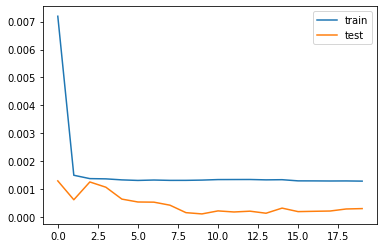

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

It appears the model made a very good guess almost immediately in this case. Previous attempts have shown that this is not always the case, and that using less data than what was used in this run to train the model is typically unreliable, and can lead to poor predictive results. 

In [ ]:
yhat = model.predict(test_X)
# make a prediction
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features)) 

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -13:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -13:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.050


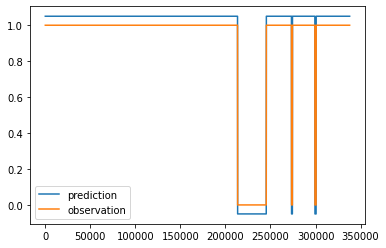

In [ ]:
# plot prediction and real result
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='observation')
pyplot.legend()
pyplot.show()

## Part 3 Two Layer Stacked LSTM - Adam optimizer

In [ ]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from tensorflow import keras
# Highly recommended for time series data
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# Processing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# keras --2019--> tf.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd

In [ ]:
# Re-load and preprocess data
dataset = pd.read_csv('complete_data_filtered.csv', header=0, index_col=1)
dataset = dataset.reset_index(drop=True)

# drop out extra index and season columns
dataset = dataset.drop(columns=["Unnamed: 0","season"])
# this leaves the index, 12 appliances, and the occupancy

# drop rows with NaN
dataset = dataset.dropna()

# drop rows with any column containing value of -1 (since this is missing
# consumption data) - Casey addded 3/31/22 2:04PM
dataset=dataset[dataset.ne(-1).all(1)]

# ensure all data is float
values = dataset.values
values = values.astype('float32')

# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [ ]:
# prepare data for lstm
# convert series to supervised learning  --> stride missing?, spaced out the data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # create 1 time lag
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# specify the number of lag observations
n_lag = 3
n_features = 13
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)

In [ ]:
# split into train and test sets
# train on approximately 50% of data set to speed computation
# actual training set is the nearest multiple of 128 (batch size) to 50% of the dataset
# test on remaining data 
train_frac=0.5
batch_sz=128
end_train = batch_sz*round(round(train_frac*len(values))/batch_sz)
values = reframed.values
train = values[:end_train, :]
test = values[end_train:, :]

# split into input and outputs
n_obs = n_lag * n_features # count in the 13 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

(844672, 39) (844672,)


In [ ]:
# design and build model with two LSTM'S
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))
model1.add(LSTM(units = 50))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1))

adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model1.fit(train_X, train_y, epochs=20, batch_size=batch_sz, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
6599/6599 - 89s - loss: 0.0051 - val_loss: 0.0024 - 89s/epoch - 13ms/step
Epoch 2/20
6599/6599 - 81s - loss: 0.0013 - val_loss: 0.0026 - 81s/epoch - 12ms/step
Epoch 3/20
6599/6599 - 86s - loss: 0.0011 - val_loss: 0.0124 - 86s/epoch - 13ms/step
Epoch 4/20
6599/6599 - 84s - loss: 0.0011 - val_loss: 0.0174 - 84s/epoch - 13ms/step
Epoch 5/20
6599/6599 - 77s - loss: 0.0011 - val_loss: 0.0120 - 77s/epoch - 12ms/step
Epoch 6/20
6599/6599 - 78s - loss: 0.0010 - val_loss: 0.0184 - 78s/epoch - 12ms/step
Epoch 7/20
6599/6599 - 79s - loss: 0.0010 - val_loss: 4.1779e-04 - 79s/epoch - 12ms/step
Epoch 8/20
6599/6599 - 90s - loss: 9.9585e-04 - val_loss: 0.0023 - 90s/epoch - 14ms/step
Epoch 9/20
6599/6599 - 77s - loss: 9.9835e-04 - val_loss: 5.8827e-05 - 77s/epoch - 12ms/step
Epoch 10/20
6599/6599 - 89s - loss: 9.8288e-04 - val_loss: 0.0010 - 89s/epoch - 13ms/step
Epoch 11/20
6599/6599 - 77s - loss: 9.8828e-04 - val_loss: 7.5449e-05 - 77s/epoch - 12ms/step
Epoch 12/20
6599/6599 - 78s - loss:

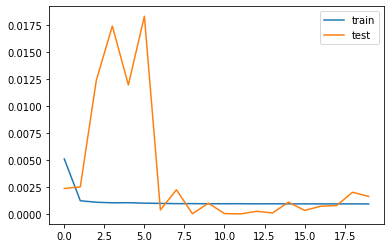

Test RMSE: 0.051


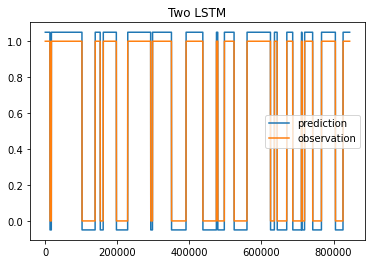

In [ ]:

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model1.predict(test_X)
test_X_rs = test_X.reshape((test_X.shape[0], n_lag*n_features)) 
# invert scaling for forecast
inv_yhat = concatenate((test_X_rs[:, -13:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_rs[:, -13:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# plot prediction and real result
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='observation')
pyplot.title('Two LSTM')
pyplot.legend()
pyplot.show()

Two layer stacked LSTM performed similar to Four layer stacked LSTM with respect to accuracy (MSE). However, the MSE during training for the Test set was oscillatory, even at the end of 20 epochs.

## Part 4 Two Layer Stacked LSTM - SGD optimizer

In [ ]:
# design and build model with two LSTM layers and SGD optimizer
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units = 50))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1))

sgd = keras.optimizers.SGD(learning_rate=0.001)
model2.compile(optimizer = 'sgd', loss = 'mean_squared_error')

history = model2.fit(train_X, train_y, epochs=20, batch_size=batch_sz, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
6599/6599 - 73s - loss: 0.0169 - val_loss: 0.0463 - 73s/epoch - 11ms/step
Epoch 2/20
6599/6599 - 70s - loss: 0.0043 - val_loss: 0.0064 - 70s/epoch - 11ms/step
Epoch 3/20
6599/6599 - 73s - loss: 0.0029 - val_loss: 0.0030 - 73s/epoch - 11ms/step
Epoch 4/20
6599/6599 - 70s - loss: 0.0025 - val_loss: 0.0022 - 70s/epoch - 11ms/step
Epoch 5/20
6599/6599 - 68s - loss: 0.0023 - val_loss: 0.0017 - 68s/epoch - 10ms/step
Epoch 6/20
6599/6599 - 69s - loss: 0.0021 - val_loss: 0.0015 - 69s/epoch - 10ms/step
Epoch 7/20
6599/6599 - 69s - loss: 0.0020 - val_loss: 0.0013 - 69s/epoch - 10ms/step
Epoch 8/20
6599/6599 - 69s - loss: 0.0020 - val_loss: 0.0011 - 69s/epoch - 10ms/step
Epoch 9/20
6599/6599 - 72s - loss: 0.0019 - val_loss: 0.0010 - 72s/epoch - 11ms/step
Epoch 10/20
6599/6599 - 69s - loss: 0.0019 - val_loss: 9.0029e-04 - 69s/epoch - 10ms/step
Epoch 11/20
6599/6599 - 68s - loss: 0.0018 - val_loss: 8.7743e-04 - 68s/epoch - 10ms/step
Epoch 12/20
6599/6599 - 69s - loss: 0.0018 - val_loss: 

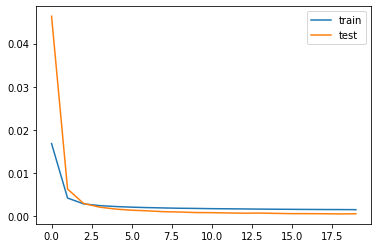

Test RMSE: 0.051


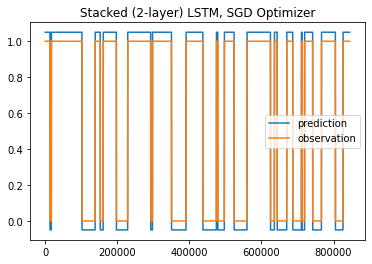

In [ ]:

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model2.predict(test_X)
test_X_rs = test_X.reshape((test_X.shape[0], n_lag*n_features)) 
# invert scaling for forecast
inv_yhat = concatenate((test_X_rs[:, -13:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_rs[:, -13:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# plot prediction and real result
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='observation')
pyplot.title('Stacked (2-layer) LSTM, SGD Optimizer')
pyplot.legend()
pyplot.show()

2-layer stacked LSTM with SGD optimizer performed similar to 2-layer stacked LSTM with adam optimizer with respect to final MSE/accuracy, but with faster and more consistent convergence (MSE vs epoch). This would indicate it could have had sufficient accuracy with fewer epochs.

In [ ]:
# serialize model to JSON
model1_json = model1.to_json()
with open("task2_2Layer_LSTM_adam.json", "w") as json_file:
     json_file.write(model1_json)
# serialize weights to HDF5
model1.save_weights("Task2_2Layer_LSTM_adam.h5")
print("Saved model to disk")

# serialize model to JSON
model2_json = model2.to_json()
with open("task2_2Layer_LSTM_SGD.json", "w") as json_file:
     json_file.write(model2_json)
# serialize weights to HDF5
model2.save_weights("Task2_2Layer_LSTM_SGD.h5")
print("Saved model to disk")

## Part 5 Stacked LSTM with larger training dataset

In terms of training dataset size, we tested two approaches. In previous attempts, we removed all the rows with measuring measurements and removed rows with NaN values. This essentially removed all dates for which Stove data was unavialable leaving us with around ~28 days plug and occupancy data. 
In this section, we attempt to train the model with the complete plugs and occupancy data ~128 days and eliminating the Stove variable. We wanted to analyze whether the training data size plays a significant role in affecting the prediction accuracy of the model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as pyplot

In [ ]:
#import filtered data
new_data = pd.read_csv('/content/drive/MyDrive/ME592 HW3/Copy of complete_data_filtered.csv')

#drop columns we will not use in the model
dataset = new_data.drop(columns = ['season','Date&Time','Unnamed: 0','Stove'])

#remove missing measurements
dataset = drop_missing_rows(dataset)

# ensure all data is float
values = dataset.values
values = values.astype('float32')

# normalize features between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#*****

#check for nan values
dataset.isna().sum()

In [ ]:
#check dataset shape and missing measurements (no -1 values must be present)
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Air Exhaust,8586828.0,0.796795,8.717609,0.0,0.0,0.00000,0.00000,179.307
Dishwasher,8586828.0,18.938439,196.636560,0.0,0.0,0.00000,0.00000,2321.110
Entertainment,8586828.0,57.461096,89.689068,0.0,0.0,0.00000,205.45500,393.848
Freezer,8586828.0,28.338232,36.378130,0.0,0.0,51.50910,53.65100,967.608
Fridge,8586828.0,25.142472,40.917891,0.0,0.0,0.00000,68.17280,1033.500
Kettle,8586828.0,6.412015,108.321486,0.0,0.0,0.00000,0.00000,1908.360
Lamp,8586828.0,15.680375,51.628563,0.0,0.0,0.00000,0.00000,317.139
Laptops,8586828.0,8.069199,19.613639,0.0,0.0,0.00000,0.00000,1613.280
Stereo,8586828.0,16.947696,24.617026,0.0,0.0,0.00000,47.57200,233.848
Tablet,8586828.0,1.218126,1.335961,0.0,0.0,2.21504,2.21504,10.672


In [ ]:
# prepare data for lstm
# convert series to supervised learning  --> stride missing?, spaced out the data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # create 1 time lag
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
	#*****

In [ ]:
# specify the number of lag observations
n_lag = 3
n_features = 12
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, 1)
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
3,0.0,0.0,0.000000,0.055447,0.002143,0.0,0.0,0.0,0.000000,0.207556,...,0.000000,0.055447,0.000000,0.0,0.0,0.0,0.000000,0.207556,0.0,1.0
4,0.0,0.0,0.005513,0.057661,0.002143,0.0,0.0,0.0,0.009285,0.405669,...,0.000000,0.057661,0.000000,0.0,0.0,0.0,0.000000,0.207556,0.0,1.0
5,0.0,0.0,0.000000,0.055447,0.000000,0.0,0.0,0.0,0.000000,0.207556,...,0.000000,0.055447,0.000000,0.0,0.0,0.0,0.000000,0.207556,0.0,1.0
6,0.0,0.0,0.000000,0.055447,0.000000,0.0,0.0,0.0,0.000000,0.207556,...,0.005513,0.055447,0.002143,0.0,0.0,0.0,0.009285,0.207556,0.0,1.0
7,0.0,0.0,0.000000,0.057661,0.000000,0.0,0.0,0.0,0.000000,0.207556,...,0.000000,0.055447,0.000000,0.0,0.0,0.0,0.000000,0.207556,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8586823,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.207556,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0
8586824,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0
8586825,0.0,0.0,0.000000,0.000000,0.002143,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0
8586826,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0


In [ ]:
# split into train and test sets
# train on only 0-70% of data set to speed computation
# test on 70-100% of data set 
end_train = round(0.7*len(values))
#end_test = end_train + round(0.1*len(values))

values = reframed.values
train = values[:end_train, :]
test = values[end_train:, :]

# split into input and outputs
n_obs = n_lag * n_features # count in the 13 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6010780, 36) (6010780,)
(6010780, 3, 12) (6010780,) (2576045, 3, 12) (2576045,)


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#design and build the LSTM
def create_model():
  model= tf.keras.Sequential([
           tf.keras.layers.LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(units = 50, return_sequences = True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(units = 50, return_sequences = True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(units = 50),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(units = 1)                  
          ])
  adam = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             12600     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
#four different cases of the model was trained and tested with the large dataset of 128 days consumption data

#Case 1: epochs = 20, batch_size = 64
#history = model.fit(train_X, train_y, epochs=20, batch_size=64, 
 #                   validation_data=(test_X, test_y), verbose=2, shuffle=False)
#Case 2: epochs = 20, batch_size = 254
#history = model.fit(train_X, train_y, epochs=20, batch_size=254, 
 #                   validation_data=(test_X, test_y), verbose=2, shuffle=False)
#Case 3: epochs = 30, batch_size = 1028
history = model.fit(train_X, train_y, epochs=30, batch_size=1028, 
                   validation_data=(test_X, test_y), verbose=2, shuffle=False)
#Case 4: epochs = 50, batch_size = 4096
# history = model.fit(train_X, train_y, epochs=50, batch_size=4096, 
#                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # serialize model to JSON
# model_json = model.to_json()
# with open("model3.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model3.h5")
# print("Saved model to disk")



Epoch 1/30
5848/5848 - 100s - loss: 0.0108 - val_loss: 1.3677e-04 - 100s/epoch - 17ms/step
Epoch 2/30
5848/5848 - 75s - loss: 0.0020 - val_loss: 1.5444e-04 - 75s/epoch - 13ms/step
Epoch 3/30
5848/5848 - 78s - loss: 0.0035 - val_loss: 6.6959e-05 - 78s/epoch - 13ms/step
Epoch 4/30
5848/5848 - 76s - loss: 0.0014 - val_loss: 9.0304e-05 - 76s/epoch - 13ms/step
Epoch 5/30
5848/5848 - 75s - loss: 0.0016 - val_loss: 1.8457e-04 - 75s/epoch - 13ms/step
Epoch 6/30
5848/5848 - 75s - loss: 0.0013 - val_loss: 1.1493e-04 - 75s/epoch - 13ms/step
Epoch 7/30
5848/5848 - 78s - loss: 0.0013 - val_loss: 6.9314e-05 - 78s/epoch - 13ms/step
Epoch 8/30
5848/5848 - 76s - loss: 0.0012 - val_loss: 4.8138e-05 - 76s/epoch - 13ms/step
Epoch 9/30
5848/5848 - 74s - loss: 0.0014 - val_loss: 1.3304e-04 - 74s/epoch - 13ms/step
Epoch 10/30
5848/5848 - 76s - loss: 0.0011 - val_loss: 2.5912e-05 - 76s/epoch - 13ms/step
Epoch 11/30
5848/5848 - 77s - loss: 0.0011 - val_loss: 3.1076e-05 - 77s/epoch - 13ms/step
Epoch 12/30
5848/

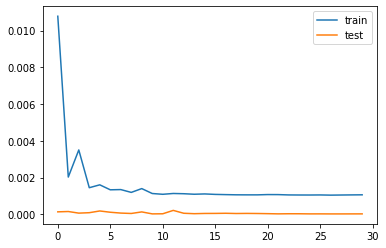

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

yhat = model.predict(test_X)
# make a prediction
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features)) 

# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, -12:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, -12:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

Test RMSE: 0.050


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


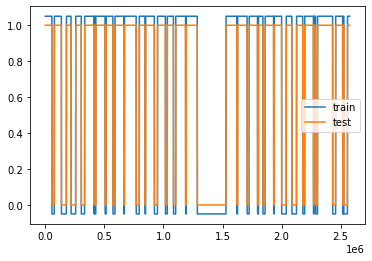

In [ ]:
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# plot prediction and real result
pyplot.plot(inv_yhat, label='train')
pyplot.plot(inv_y, label='test')
pyplot.legend()
pyplot.show()

Using the complete data ~128 days did not prove to be more effective than the subset of 28 days. The RMSE value did not improve significantly. Increase the training data size only increased the computational time, which had to be compensated by increasing the batch size. Also, even at 50 epochs, the training and test loss values did not converge. Hence, we conclude that simply increasing the data size does not provide better results. 

## Part 6 Isolate Key Variables ##



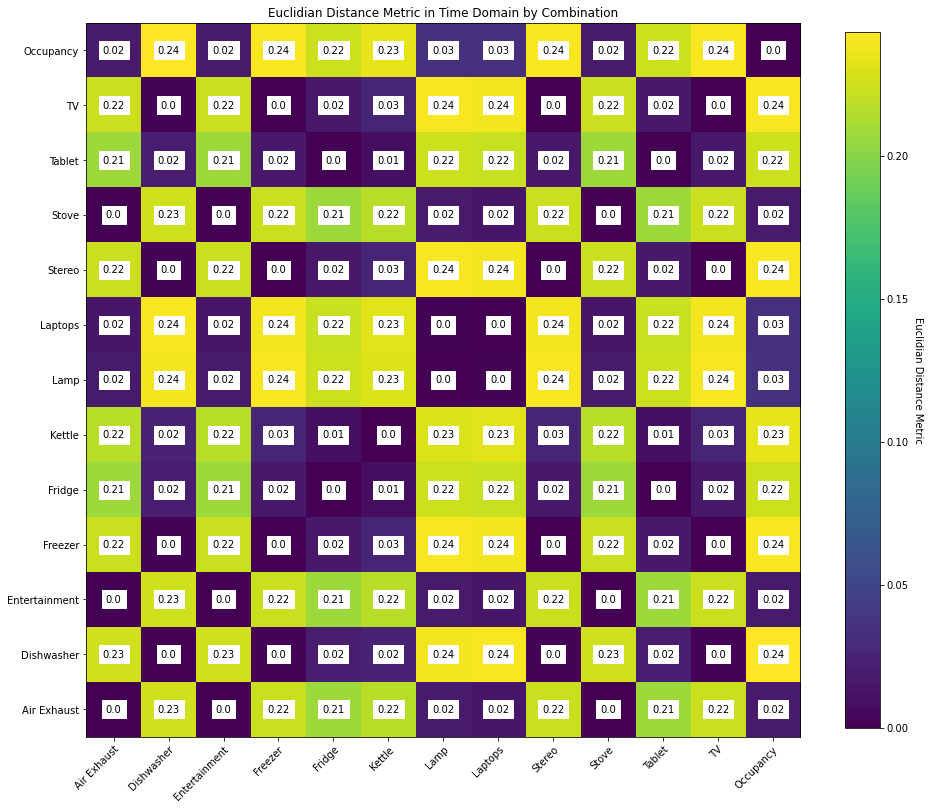

In [ ]:
# In order to determine what the key variables are affecting Occupancy, we can
# use the Euclidian Distance metric to analyze for similarities between arrays.
# As discussed in previous homework, lower Euclidian Distance means greater
# similarities. 

#Define function to calculate euclidian distance metric
#Euclidian distance metric is calculated as sum of absolute values of element-wise differences between array1 and array2
def calculate_euclidian_dist(array1,array2):
  distance_metric=np.sum(np.abs(array1-array2))
  return distance_metric

#The following concatenates the five use cases to allow for indexing in a for loop.
#The nested for loop creates a 13x13 array containing the euclidian distance metric
#between each use case.
use_case = ['Air Exhaust','Dishwasher','Entertainment','Freezer','Fridge',
            'Kettle','Lamp','Laptops','Stereo','Stove','Tablet','TV','Occupancy']
euclid_dist_array=np.zeros((13,13))
for x in range (0,13):
  for y in range (0,13):
      euclid_dist_array[x,y]=calculate_euclidian_dist(scaled[x],scaled[y])

#Plot the euclidian distance metrics for each use case combination    
fig, ax = pyplot.subplots(figsize=(16,16))
im=ax.imshow(euclid_dist_array,origin='lower')
ax.set_xticks(np.arange(len(use_case)))
ax.set_yticks(np.arange(len(use_case)))
ax.set_xticklabels(use_case)
ax.set_yticklabels(use_case)
cbar = ax.figure.colorbar(im, ax=ax,shrink=0.8)
cbar.ax.set_ylabel('Euclidian Distance Metric', rotation=-90, va="bottom")
pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
for j in range(len(use_case)):
    for i in range(len(use_case)):
        text = ax.text(j, i, np.round(euclid_dist_array[i, j],2),ha="center", va="center", backgroundcolor="w")
ax.set_title("Euclidian Distance Metric in Time Domain by Combination")
pyplot.show()

In [ ]:
# look at results of last column of euclidian distance metric to see what
# appliances are most similar to occupancy
for k in range(len(use_case)):
  print("The Euclidian Distance metric between Occupancy and ", use_case[k],
        " is ", euclid_dist_array[k,12])

The Euclidian Distance metric between Occupancy and  Air Exhaust  is  0.01731240563094616
The Euclidian Distance metric between Occupancy and  Dishwasher  is  0.2432912290096283
The Euclidian Distance metric between Occupancy and  Entertainment  is  0.01731240563094616
The Euclidian Distance metric between Occupancy and  Freezer  is  0.24105288088321686
The Euclidian Distance metric between Occupancy and  Fridge  is  0.22486862540245056
The Euclidian Distance metric between Occupancy and  Kettle  is  0.23425132036209106
The Euclidian Distance metric between Occupancy and  Lamp  is  0.03468833491206169
The Euclidian Distance metric between Occupancy and  Laptops  is  0.03244998678565025
The Euclidian Distance metric between Occupancy and  Stereo  is  0.24105288088321686
The Euclidian Distance metric between Occupancy and  Stove  is  0.01731240563094616
The Euclidian Distance metric between Occupancy and  Tablet  is  0.22486862540245056
The Euclidian Distance metric between Occupancy and

In [ ]:
# Based on this, we can see that the three applicances with the most similarity
# are Air Exhaust, Entertainment, and Stove. The other two applicances in the 
# top five are Laptops and Lamp. We will try two additional stacked LSTM
# networks, one with only the top three closest appliances and one with the top
# five closest appliances.

In [ ]:
# load dataset, use same naming convension as that of Task 1 for ease
# of use
dataset = pd.read_csv('Copy of complete_data_filtered.csv', header=0, index_col=1)

# drop out date and time
dataset = dataset.reset_index(drop=True)

In [ ]:
# drop out index, season, and extra appliance columns
dataset_top5 = dataset.drop(columns=["Unnamed: 0","season","Dishwasher","Freezer",
                                     "Fridge","Kettle","Stereo","Tablet","TV"])
dataset_top3 = dataset.drop(columns=["Unnamed: 0","season","Dishwasher","Freezer",
                                     "Fridge","Kettle","Lamp","Laptops","Stereo",
                                     "Tablet","TV"])

# drop rows with NaN
dataset_top5 = dataset_top5.dropna()
dataset_top3 = dataset_top3.dropna()

# drop rows with any column containing value of -1 (since this is missing
# consumption data)
dataset_top5 =dataset_top5[dataset_top5.ne(-1).all(1)]
dataset_top3 =dataset_top3[dataset_top3.ne(-1).all(1)]

# ensure all data is float
values_top5 = dataset_top5.values
values_top5 = values_top5.astype('float32')
values_top3 = dataset_top3.values
values_top3 = values_top3.astype('float32')

# normalize features between 0 to 1
scaler_top5 = MinMaxScaler(feature_range=(0, 1))
scaled_top5 = scaler_top5.fit_transform(values_top5)
scaler_top3 = MinMaxScaler(feature_range=(0, 1))
scaled_top3 = scaler_top3.fit_transform(values_top3)

In [ ]:
scaled_top5.shape

(1737509, 6)

In [ ]:
scaled_top3.shape

(2241300, 4)

## Part 7 Four Layer, 5 Inputs ##

In [ ]:
# run four layer stacked LSTM on the top 5 appliances to see if performance is
# affected

# specify the number of lag observations
n_lag = 3
n_features = 6
# frame as supervised learning
reframed_top5 = series_to_supervised(scaled_top5, n_lag, 1)
reframed_top5


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.0,0.162959,0.0,0.394538,0.0,1.0,0.0,0.168774,0.000000,0.394538,...,0.000000,0.394538,0.0,1.0,0.0,0.168774,0.000000,0.394538,0.0,1.0
4,0.0,0.168774,0.0,0.394538,0.0,1.0,0.0,0.162959,0.000000,0.394538,...,0.000000,0.394538,0.0,1.0,0.0,0.162959,0.000000,0.394538,0.0,1.0
5,0.0,0.162959,0.0,0.394538,0.0,1.0,0.0,0.168774,0.000000,0.394538,...,0.000000,0.394538,0.0,1.0,0.0,0.162959,0.007144,0.394538,0.0,1.0
6,0.0,0.168774,0.0,0.394538,0.0,1.0,0.0,0.162959,0.000000,0.394538,...,0.007144,0.394538,0.0,1.0,0.0,0.162959,0.000000,0.409676,0.0,1.0
7,0.0,0.162959,0.0,0.394538,0.0,1.0,0.0,0.162959,0.007144,0.394538,...,0.000000,0.409676,0.0,1.0,0.0,0.162959,0.000000,0.409676,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737504,0.0,0.064111,0.0,0.000000,0.0,1.0,0.0,0.058296,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.0,0.058296,0.000000,0.000000,0.0,1.0
1737505,0.0,0.058296,0.0,0.000000,0.0,1.0,0.0,0.058296,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.0,0.064111,0.000000,0.000000,0.0,1.0
1737506,0.0,0.058296,0.0,0.000000,0.0,1.0,0.0,0.058296,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.0,0.064111,0.000000,0.000000,0.0,1.0
1737507,0.0,0.058296,0.0,0.000000,0.0,1.0,0.0,0.064111,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.0,0.058296,0.000000,0.000000,0.0,1.0


In [ ]:
# split into train and test sets
# train on only 0-30% of data set to speed computation
# test on 30-50% of data set 
end_train = round(0.3*len(scaled_top5))
end_test = end_train + round(0.2*len(scaled_top5))

values = reframed_top5.values
train = values[:end_train, :]
test = values[end_train:end_test, :]

# split into input and outputs
n_obs = n_lag * n_features # count in the 6 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(521253, 18) (521253,)
(521253, 3, 6) (521253,) (347502, 3, 6) (347502,)


In [ ]:
# design and build up LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(train_X, train_y, epochs=20, batch_size=64, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
8145/8145 - 143s - loss: 0.0071 - val_loss: 0.0020 - 143s/epoch - 17ms/step
Epoch 2/20
8145/8145 - 131s - loss: 0.0015 - val_loss: 6.3064e-04 - 131s/epoch - 16ms/step
Epoch 3/20
8145/8145 - 132s - loss: 0.0015 - val_loss: 0.0014 - 132s/epoch - 16ms/step
Epoch 4/20
8145/8145 - 134s - loss: 0.0013 - val_loss: 0.0016 - 134s/epoch - 16ms/step
Epoch 5/20
8145/8145 - 132s - loss: 0.0013 - val_loss: 0.0019 - 132s/epoch - 16ms/step
Epoch 6/20
8145/8145 - 132s - loss: 0.0013 - val_loss: 8.3935e-04 - 132s/epoch - 16ms/step
Epoch 7/20
8145/8145 - 132s - loss: 0.0013 - val_loss: 0.0013 - 132s/epoch - 16ms/step
Epoch 8/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 4.2210e-04 - 131s/epoch - 16ms/step
Epoch 9/20
8145/8145 - 130s - loss: 0.0013 - val_loss: 7.2521e-04 - 130s/epoch - 16ms/step
Epoch 10/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 6.0727e-04 - 131s/epoch - 16ms/step
Epoch 11/20
8145/8145 - 132s - loss: 0.0013 - val_loss: 5.2657e-04 - 132s/epoch - 16ms/step
Epoch 12/20
8145/

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model3.json", "w") as json_file:
     json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3.h5")
print("Saved model to disk")

Saved model to disk


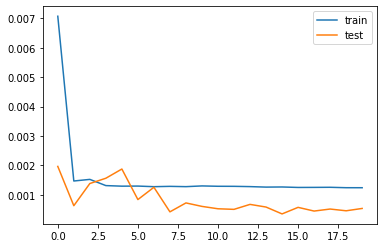

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

In [ ]:
yhat = model.predict(test_X)
# make a prediction
test_X_rs = test_X.reshape((test_X.shape[0], n_lag*n_features)) 
test_X.shape

(347502, 3, 6)

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((test_X_rs[:, -6:-1], yhat), axis=1)

In [ ]:
inv_yhat = scaler_top5.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_rs[:, -6:-1], test_y), axis=1)
inv_y = scaler_top5.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.050


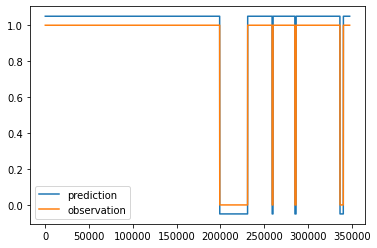

In [ ]:
# plot prediction and real result
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='observation')
pyplot.legend()
pyplot.show()

As can be seen from the RSME and test data, the stacked LSTM with four layers was not negatively impacted by only using the 5 inputs that had the closest similarity based on the Euclidian Distance Metric.  

## Part 8 Four Layer, 3 Inputs ##

In [ ]:
# run four layer stacked LSTM on the top 3 appliances to see if performance is
# affected

# specify the number of lag observations
n_lag = 3
n_features = 4
# frame as supervised learning
reframed_top3 = series_to_supervised(scaled_top3, n_lag, 1)
reframed_top3

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
3,0.0,0.005961,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0
4,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0
5,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.005961,0.0,1.0
6,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.005961,0.0,1.0,0.0,0.000000,0.0,1.0
7,0.0,0.000000,0.0,1.0,0.0,0.005961,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241295,0.0,0.064111,0.0,1.0,0.0,0.058296,0.0,1.0,0.0,0.058296,0.0,1.0,0.0,0.058296,0.0,1.0
2241296,0.0,0.058296,0.0,1.0,0.0,0.058296,0.0,1.0,0.0,0.058296,0.0,1.0,0.0,0.064111,0.0,1.0
2241297,0.0,0.058296,0.0,1.0,0.0,0.058296,0.0,1.0,0.0,0.064111,0.0,1.0,0.0,0.064111,0.0,1.0
2241298,0.0,0.058296,0.0,1.0,0.0,0.064111,0.0,1.0,0.0,0.064111,0.0,1.0,0.0,0.058296,0.0,1.0


In [ ]:
# split into train and test sets
# train on only 0-30% of data set to speed computation
# test on 30-50% of data set 
end_train = round(0.3*len(values))
end_test = end_train + round(0.2*len(values))

values = reframed_top5.values
train = values[:end_train, :]
test = values[end_train:end_test, :]

# split into input and outputs
n_obs = n_lag * n_features # count in the 4 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(521252, 12) (521252,)
(521252, 3, 4) (521252,) (347501, 3, 4) (347501,)


In [ ]:
# design and build up LSTM network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(train_X, train_y, epochs=20, batch_size=64, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
8145/8145 - 144s - loss: 0.0111 - val_loss: 0.0044 - 144s/epoch - 18ms/step
Epoch 2/20
8145/8145 - 130s - loss: 0.0022 - val_loss: 0.0027 - 130s/epoch - 16ms/step
Epoch 3/20
8145/8145 - 133s - loss: 0.0014 - val_loss: 0.0021 - 133s/epoch - 16ms/step
Epoch 4/20
8145/8145 - 130s - loss: 0.0013 - val_loss: 0.0027 - 130s/epoch - 16ms/step
Epoch 5/20
8145/8145 - 132s - loss: 0.0025 - val_loss: 7.0891e-04 - 132s/epoch - 16ms/step
Epoch 6/20
8145/8145 - 130s - loss: 0.0013 - val_loss: 0.0014 - 130s/epoch - 16ms/step
Epoch 7/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 0.0012 - 131s/epoch - 16ms/step
Epoch 8/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 8.8063e-04 - 131s/epoch - 16ms/step
Epoch 9/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 0.0010 - 131s/epoch - 16ms/step
Epoch 10/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 6.9983e-04 - 131s/epoch - 16ms/step
Epoch 11/20
8145/8145 - 131s - loss: 0.0013 - val_loss: 9.1677e-04 - 131s/epoch - 16ms/step
Epoch 12/20
8145/8145 - 1

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model3.json", "w") as json_file:
     json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3.h5")
print("Saved model to disk")

Saved model to disk


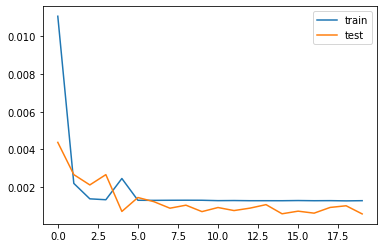

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

In [ ]:
yhat = model.predict(test_X)
# make a prediction
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features)) 

In [ ]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -4:-1], yhat), axis=1)
inv_yhat = scaler_top3.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
inv_yhat = np.where(inv_yhat < 0.1, -0.05, 1.05) # make the plot easier to see
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -4:-1], test_y), axis=1)
inv_y = scaler_top3.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.051


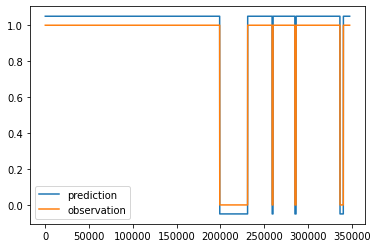

In [ ]:
# plot prediction and real result
pyplot.plot(inv_yhat, label='prediction')
pyplot.plot(inv_y, label='observation')
pyplot.legend()
pyplot.show()

Similar to the results from the 5 Input test, as can be seen from the RSME and test data, the stacked LSTM with four layers was not negatively impacted by only using the 3 inputs that had the closest similarity based on the Euclidian Distance Metric.

This is has significant implications for future data collection, since future timepoints would only need these 3 inputs - Air Exhaust, Entertainment, and Stove - in order to predict occupancy.